# Estadistica Bayesiana
## Ejemplo del lanzamiento de una moneda
###### https://www.chreinvent.com/recursos/moneda-bayesiana
###### https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.ipynb
Supongamos, de manera ingenua, que no estás seguro de la probabilidad de obtener cara al lanzar una moneda (advertencia: es 50%). 
+ Crees que hay una proporción subyacente verdadera, a la que llamaremos p, pero no tienes una opinión previa sobre cuál podría ser el valor de p.

Proceso de observación
+ Comenzamos a lanzar una moneda y registramos las observaciones: ya sea cara (H) o cruz (T). Estos son nuestros datos observados. 
+ Una pregunta interesante es:
    + **¿cómo cambia nuestra inferencia a medida que observamos más y más datos?**

+ Más específicamente, 
    + **¿cómo se ven nuestras probabilidades posteriores cuando tenemos pocos datos, en comparación con cuando tenemos muchos datos?**


Progresión de las probabilidades posteriores

A medida que observamos lanzamientos sucesivos:
+ Comenzamos con una creencia previa (prior), que puede ser completamente uniforme (es decir, no tenemos una inclinación hacia ningún valor particular de p).
+ Con cada lanzamiento, actualizamos esta creencia previa utilizando el Teorema de Bayes para obtener una probabilidad posterior (posterior).
+ La probabilidad posterior refleja nuestra confianza actualizada sobre p, considerando los datos observados hasta ese momento.

Visualización

+ Al graficar una secuencia de probabilidades posteriores:
    + Con pocos datos: Las distribuciones suelen ser amplias, lo que indica mucha incertidumbre sobre el verdadero valor de p.

    + Con muchos datos: Las distribuciones se vuelven más estrechas y centradas alrededor del valor verdadero (idealmente, p=0.5 en este caso).

+   Este ejemplo simple demuestra cómo el enfoque bayesiano se adapta dinámicamente a los datos disponibles, 
    + preservando la incertidumbre inicial y refinando progresivamente las creencias a medida que se acumula evidencia.

In [3]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


from __future__ import absolute_import, division, print_function


#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
           tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from 'c:\\Users\\Dani\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\tensorflow\\_api\\v2\\config\\__init__.py'>

In [ ]:
# Se define una distribución Bernoulli con una probabilidad de 0.5 para cada lanzamiento. Esto representa una creencia inicial de que la moneda es justa.
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5, dtype=tf.int32)

# Se simulan 2000 lanzamientos de moneda.
num_trials = tf.constant([0,1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])

# El número de lanzamientos relevantes se selecciona a partir del array num_trials.
coin_flip_data = rv_coin_flip_prior.sample(num_trials[-1])

# prepend a 0 onto tally of heads and tails, for zeroth flip
coin_flip_data = tf.pad(coin_flip_data,tf.constant([[1, 0,]]),"CONSTANT")

# compute cumulative headcounts from 0 to 2000 flips, and then grab them at each of num_trials intervals
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials)

rv_observed_heads = tfp.distributions.Beta(
    concentration1=tf.cast(1 + cumulative_headcounts, tf.float32),
    concentration0=tf.cast(1 + num_trials - cumulative_headcounts, tf.float32))

probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace")
observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis]))


In [5]:
# Build Graph
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5, dtype=tf.int32)

num_trials = tf.constant([0,1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])

coin_flip_data = rv_coin_flip_prior.sample(num_trials[-1])

# prepend a 0 onto tally of heads and tails, for zeroth flip
coin_flip_data = tf.pad(coin_flip_data,tf.constant([[1, 0,]]),"CONSTANT")

# compute cumulative headcounts from 0 to 2000 flips, and then grab them at each of num_trials intervals
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials)

rv_observed_heads = tfp.distributions.Beta(
    concentration1=tf.cast(1 + cumulative_headcounts, tf.float32),
    concentration0=tf.cast(1 + num_trials - cumulative_headcounts, tf.float32))

probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace")
observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis]))


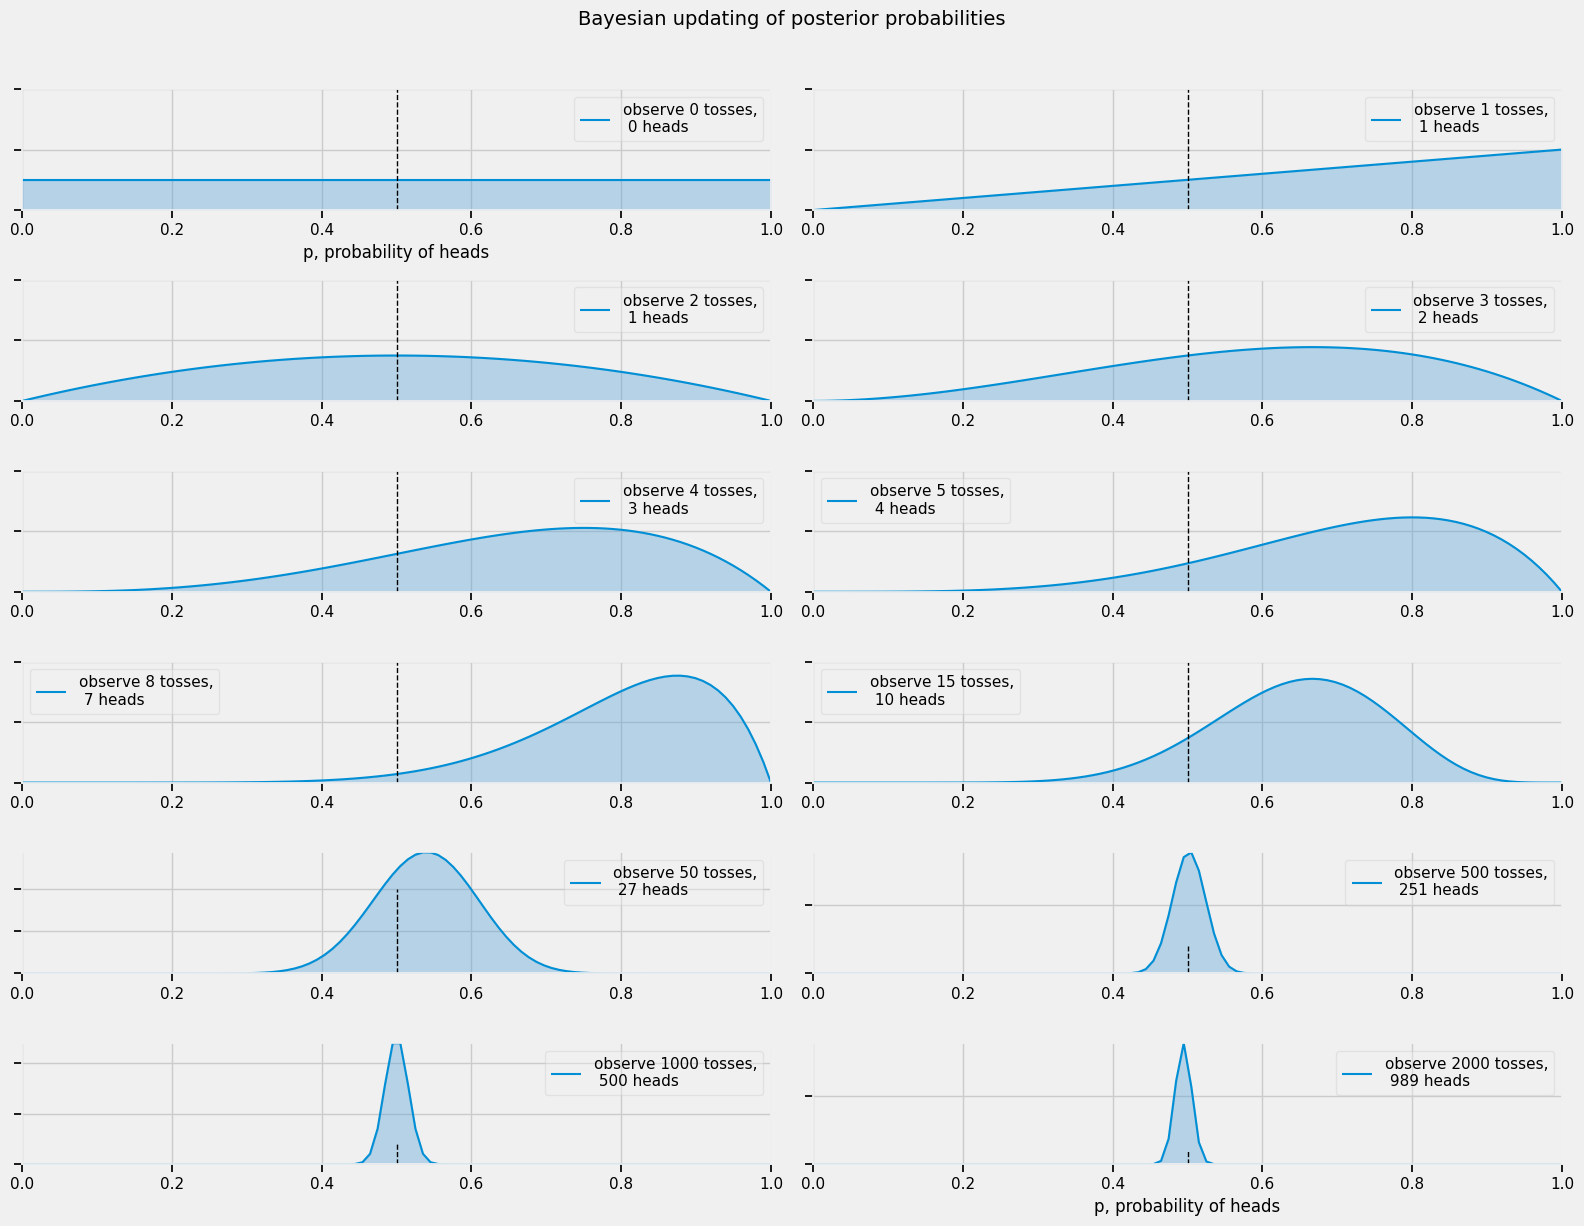

In [12]:
# For the already prepared, I'm using Binomial's conj. prior.
plt.figure(figsize(16, 12))
for i in range(len(num_trials)):
    sx = plt.subplot(len(num_trials) //2, 2, i+1)
    plt.xlabel("p, probability of heads") \
    if i in [0, len(num_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads, observed_probs_heads[i], 
             label="observe %d tosses,\n %d heads" % (num_trials[i], cumulative_headcounts[i]))
    plt.fill_between(probs_of_heads, 0, observed_probs_heads[i], 
                     color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()
     

___________________________________________________________________________________________________________________